In [1]:
# Change working directory to parent so we can import as we would from main.py
%cd ..

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import log2
from scipy.stats import fit, exponnorm, gaussian_kde

import configuration as config

from IPython.display import Image

/mnt/arkk/llm_detector/classifier


# Perplexity ratio score: Kullback–Leibler divergence

Plan here is to take our sampling distributions of perplexity ratio scores for human and synthetic text and use them to generate a function that takes a perplexity ratio score and converts it into a Kullback-Leibler score. See the figure below from the [Wikipedia article on KL divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence).

In [2]:
Image(url = 'https://raw.githubusercontent.com/gperdrizet/llm_detector/benchmarking/benchmarking/notebooks/images/KL-Gauss-Example.png')

Plan is as follows:
1. Load perplexity ratio scores from the training data.
2. Plot and fit the distributions of scores from human and synthetic text.
3. Calculate the Kullback-Leibler divergence between the fitted distributions.
4. Use a Gaussian kernel density estimate of the Kullback-Leibler divergence to get it's probability density function.
5. Use the PDF to calculate a KL score from the perplexity ratio score for each text fragment in the training and testing datasets.

In [3]:
# Load the training data
training_data_df = pd.read_json(config.COMBINED_SCORED_HANS_TRAINING_DATA)

# Replace and remove string 'OOM' and 'NAN' values
training_data_df.replace('NAN', np.nan, inplace = True)
training_data_df.replace('OOM', np.nan, inplace = True)
training_data_df.dropna(inplace = True)

# Fix some d-types
data_df = training_data_df.astype({
    'Fragment length (tokens)': int, 
    'Perplexity': float,
    'Cross-perplexity': float,
    'Perplexity ratio score': float
})

training_data_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 96810 entries, 0 to 96809
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Fragment length (tokens)  96810 non-null  int64  
 1   Dataset                   96810 non-null  object 
 2   Source                    96810 non-null  object 
 3   String                    96810 non-null  object 
 4   Perplexity                96810 non-null  float64
 5   Cross-perplexity          96810 non-null  float64
 6   Perplexity ratio score    96810 non-null  float64
dtypes: float64(3), int64(1), object(3)
memory usage: 5.9+ MB


In [4]:
# Extract perplexity score ratios as lists
scores = training_data_df['Perplexity ratio score']
human_scores = training_data_df['Perplexity ratio score'][training_data_df['Source'] == 'human']
synthetic_scores = training_data_df['Perplexity ratio score'][training_data_df['Source'] == 'synthetic']

# Set up bins for the combined dataset
counts, bins = np.histogram(scores, bins = 100, density = True)

# Get bin centers
bin_centers = (bins[:-1] + bins[1:]) / 2

# Calculate histograms for the human and synthetic data
human_density, human_bins = np.histogram(human_scores, bins = bins, density = True)
synthetic_density, synthetic_bins = np.histogram(synthetic_scores, bins = bins, density = True)

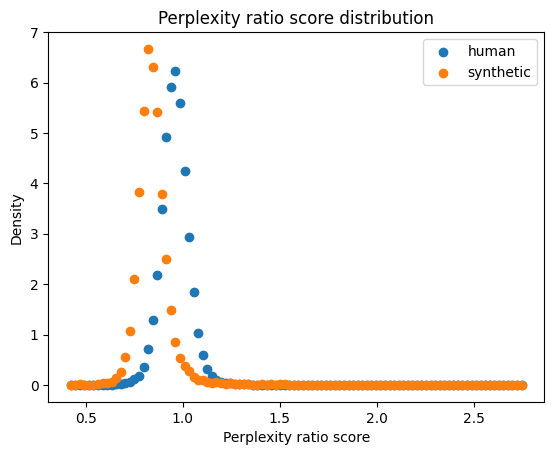

In [5]:
# Plot as scatter
plt.scatter(bin_centers, human_density, label = 'human')
plt.scatter(bin_centers, synthetic_density, label = 'synthetic')

plt.title('Perplexity ratio score distribution')
plt.xlabel('Perplexity ratio score')
plt.ylabel('Density')
plt.legend(loc = 'upper right')
plt.show()

Now, fit the individual distributions with an exponential Gaussian:

In [6]:
# Exponential Gaussian
bounds = [[0,10],[0.6,1.2],[0,10]]

human_exponnorm = fit(exponnorm, human_scores, bounds = bounds)
human_exponnorm_fit = exponnorm(human_exponnorm.params.K, human_exponnorm.params.loc, human_exponnorm.params.scale).pdf(bin_centers)

synthetic_exponnorm = fit(exponnorm, synthetic_scores, bounds = bounds)
synthetic_exponnorm_fit = exponnorm(synthetic_exponnorm.params.K, synthetic_exponnorm.params.loc, synthetic_exponnorm.params.scale).pdf(bin_centers)

/mnt/arkk/llm_detector/.venv/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1636: RuntimeWarning: overflow encountered in divide
  x = asarray((x-loc) / scale)


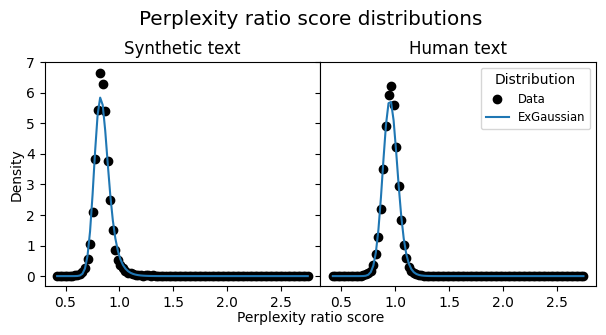

In [7]:
fig, axs = plt.subplots(
    1,
    2,
    figsize = (6, 3),
    sharex = 'col',
    sharey = 'row',
    tight_layout = True,
    gridspec_kw = {'wspace':0, 'hspace':0}
)

axs[0].set_title('Synthetic text')
axs[0].scatter(bin_centers, synthetic_density, color = 'black', label = 'Data')
axs[0].plot(bin_centers, synthetic_exponnorm_fit, label = 'ExGaussian')

axs[1].set_title('Human text')
axs[1].scatter(bin_centers, human_density, color = 'black', label = 'Data')
axs[1].plot(bin_centers, human_exponnorm_fit, label = 'ExGaussian')

axs[1].legend(
    title = 'Distribution',
    loc = 'upper right',
    fontsize = 'small'
)

# Set figure title
fig.text(0.5, 1, 'Perplexity ratio score distributions', ha = 'center', fontsize = 'x-large')

# Set single label for shared x
fig.text(0.5, 0.01, 'Perplexity ratio score', ha = 'center')

# Set single label for shared y
fig.text(0.01, 0.5, 'Density', va = 'center', ha = 'center', rotation = 90)

plt.show()

Ok, looks good to me - let's take a closer look at the fits.

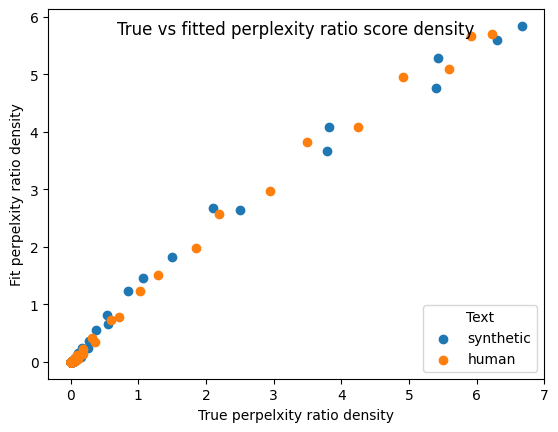

In [8]:
plt.title('True vs fitted perplexity ratio score density', y = 1.0, pad = -18)
plt.scatter(synthetic_density, synthetic_exponnorm_fit, label = 'synthetic')
plt.scatter(human_density, human_exponnorm_fit, label = 'human')
plt.legend(title = 'Text', loc = 'lower right')
plt.xlabel('True perpelxity ratio density')
plt.ylabel('Fit perpelxity ratio density')
plt.show()

OK, looks good enough to me - now let's take a look at the Kulback-Libler divergence of the two fits.

In [9]:
def kl_divergence(p, q):
    '''Takes two lists, calculates KL divergence'''

    return [p[i] * log2(p[i]/q[i]) for i in range(len(p))]

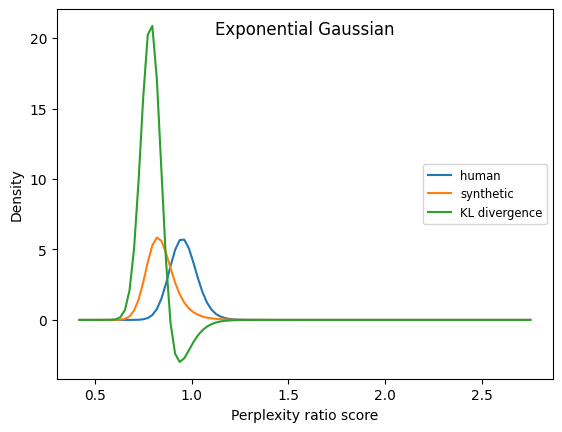

In [10]:
plt.title('Exponential Gaussian', y = 1.0, pad = -18)
plt.plot(bin_centers, human_exponnorm_fit, label = 'human')
plt.plot(bin_centers, synthetic_exponnorm_fit, label = 'synthetic')
plt.plot(bin_centers, kl_divergence(synthetic_exponnorm_fit, human_exponnorm_fit), label = 'KL divergence')
plt.xlabel('Perplexity ratio score')
plt.ylabel('Density')
plt.legend(loc = 'center right', fontsize = 'small')
plt.show()

Now we need to use fitted perplexity ratio score distributions to calculate and add the KL score for each text fragment in the dataset.

In [11]:
# Get a kernel density estimate of the KL divergence so we can use the
# associated probability density function to convert perplexity ratio scores
# into KL scores

# Get a list of points covering the range of score values
x = np.arange(min(scores) - 0.25, max(scores) + 0.25, 0.001).tolist()
print(f'Will calculate {len(x)} fitted values')

# Do the exponential gaussian fits and get values for f(x)
bounds = [[0,10],[0.6,1.2],[0,10]]

human_exponnorm = fit(exponnorm, human_scores, bounds = bounds)
human_exponnorm_fit = exponnorm(human_exponnorm.params.K, human_exponnorm.params.loc, human_exponnorm.params.scale).pdf(x)

synthetic_exponnorm = fit(exponnorm, synthetic_scores, bounds = bounds)
synthetic_exponnorm_fit = exponnorm(synthetic_exponnorm.params.K, synthetic_exponnorm.params.loc, synthetic_exponnorm.params.scale).pdf(x)

# Calculate the KL divergence of the fitted values
kl = kl_divergence(synthetic_exponnorm_fit, human_exponnorm_fit)

print(f'\nHuman K: {human_exponnorm.params.K}')
print(f'Human loc: {human_exponnorm.params.loc}')
print(f'Human scale: {human_exponnorm.params.scale}')

print(f'\nSynthetic K: {synthetic_exponnorm.params.K}')
print(f'Synthetic loc: {synthetic_exponnorm.params.loc}')
print(f'Synthetic scale: {synthetic_exponnorm.params.scale}\n')

print(f'Have {len(kl)} KL divergence values')

Will calculate 2849 fitted values


/mnt/arkk/llm_detector/.venv/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:1782: RuntimeWarning: overflow encountered in scalar divide
  invK = 1.0 / K



Human K: 0.6380326749050133
Human loc: 0.9206897810019109
Human scale: 0.06056387398582395

Synthetic K: 1.1260091620087542
Synthetic loc: 0.7876627562003873
Synthetic scale: 0.05114084141815388

Have 2849 KL divergence values


Min KL count value 0
Max KL count value: 2414


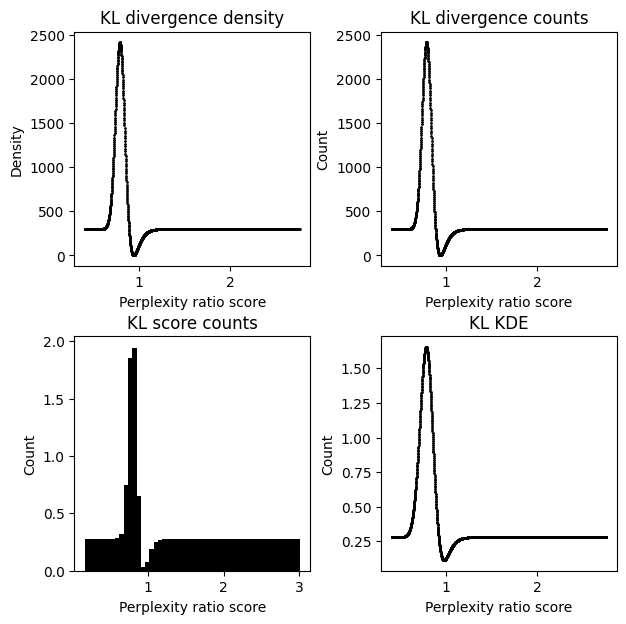

In [12]:
# Convert the kl 'density' values into integer 'count' values
kl = kl_divergence(synthetic_exponnorm_fit, human_exponnorm_fit)
kl = kl + abs(min(kl))
kl = kl * 100
kl_counts = [int(density) for density in kl]

print(f'Min KL count value {min(kl_counts)}')
print(f'Max KL count value: {max(kl_counts)}')

# Now, construct a list where each value of x appears a number of times
# equal to it's kl 'count'
kl_scores = []

for i in range(len(kl_counts)):
    kl_scores.extend([x[i]] * kl_counts[i])

# Finally, run a KDE on the reconstructed KL scores
kl_kde = gaussian_kde(kl_scores)

# And use it's PDF to get density for x after re-clipping x to the
# range of the original data
clipped_x = []
clipped_kl = []
clipped_kl_counts = []

for i, j in enumerate(x):
    if j > min(scores) and j < max(scores):
        clipped_x.append(j)
        clipped_kl.append(kl[i])
        clipped_kl_counts.append(kl_counts[i])

clipped_kl_kde_values = kl_kde.pdf(clipped_x)

fig, axs = plt.subplots(
    2,
    2,
    figsize = (7, 7),
    gridspec_kw = {'wspace':0.3, 'hspace':0.3}
)

axs[0,0].set_title('KL divergence density')
axs[0,0].scatter(clipped_x, clipped_kl, color='black', s = 1)
axs[0,0].set_xlabel('Perplexity ratio score')
axs[0,0].set_ylabel('Density')

axs[0,1].set_title('KL divergence counts')
axs[0,1].scatter(clipped_x, clipped_kl_counts, color='black', s = 1)
axs[0,1].set_xlabel('Perplexity ratio score')
axs[0,1].set_ylabel('Count')

axs[1,0].set_title('KL score counts')
axs[1,0].hist(kl_scores, bins=50, color='black', density = True)
axs[1,0].set_xlabel('Perplexity ratio score')
axs[1,0].set_ylabel('Count')

axs[1,1].set_title('KL KDE')
axs[1,1].scatter(clipped_x, clipped_kl_kde_values, color='black', s = 1)
axs[1,1].set_xlabel('Perplexity ratio score')
axs[1,1].set_ylabel('Count')

plt.show()

OK, cool. Looks good. Now we can run the perplexity ratio score column from the Hans text fragment data through the KL KDE's PDF and add the result to the dataframe.

In [13]:
kl_scores = kl_kde.pdf(training_data_df['Perplexity ratio score'])
training_data_df['Perplexity ratio Kullback-Leibler score'] = kl_scores

training_data_df.info()
print()
training_data_df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 96810 entries, 0 to 96809
Data columns (total 8 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Fragment length (tokens)                 96810 non-null  int64  
 1   Dataset                                  96810 non-null  object 
 2   Source                                   96810 non-null  object 
 3   String                                   96810 non-null  object 
 4   Perplexity                               96810 non-null  float64
 5   Cross-perplexity                         96810 non-null  float64
 6   Perplexity ratio score                   96810 non-null  float64
 7   Perplexity ratio Kullback-Leibler score  96810 non-null  float64
dtypes: float64(4), int64(1), object(3)
memory usage: 6.6+ MB



,Fragment length (tokens),Dataset,Source,String,Perplexity,Cross-perplexity,Perplexity ratio score,Perplexity ratio Kullback-Leibler score
0,179,pubmed-falcon7,human,"\n age , sex , final education , the average m...",2.549562,2.746482,0.928301,0.249963
1,227,cnn-llama2-13,synthetic,we are seeing this season is a far cry from th...,2.594488,3.453265,0.751314,1.482386
2,244,cnn-llama2-13,human,been performed for thousands of years. In some...,2.951859,3.093754,0.954135,0.144318
3,178,cc_news-llama2-13,human,or machinations in the 2016 campaign as ground...,2.474184,3.026876,0.817405,1.516302
4,173,pubmed-llama2-13,human,progenitor cell and one postmitotic neuron ....,2.665275,2.825413,0.943322,0.177393


Re-plot just to be sure we got the result we expected

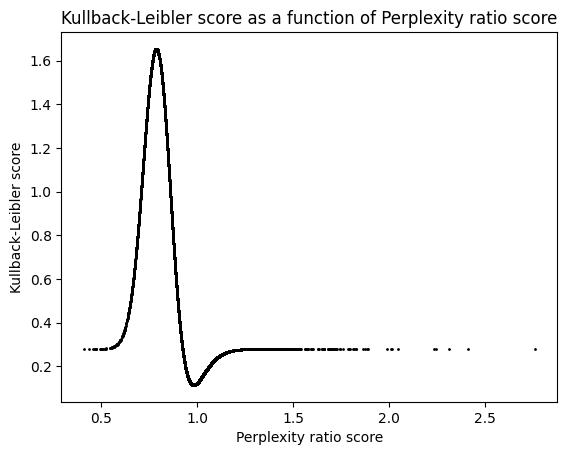

In [14]:
plt.title('Kullback-Leibler score as a function of Perplexity ratio score')
plt.scatter(training_data_df['Perplexity ratio score'], training_data_df['Perplexity ratio Kullback-Leibler score'], color='black', s = 1)
plt.xlabel('Perplexity ratio score')
plt.ylabel('Kullback-Leibler score')
plt.show()

Nailed it! Save for the next step.

In [15]:
# Save as JSON for later use
output_file = config.COMBINED_SCORED_HANS_TRAINING_DATA_PR

with open(output_file, 'w') as file:
    file.write(training_data_df.to_json())

Now do the same thing with the test data, using the PDF derived from the training data

In [16]:
# Load the testing data
testing_data_df = pd.read_json(config.COMBINED_SCORED_HANS_TESTING_DATA)

# Replace and remove string 'OOM' and 'NAN' values
testing_data_df.replace('NAN', np.nan, inplace = True)
testing_data_df.replace('OOM', np.nan, inplace = True)
testing_data_df.dropna(inplace = True)

# Fix some d-types
testing_data_df = testing_data_df.astype({
    'Fragment length (tokens)': int, 
    'Perplexity': float,
    'Cross-perplexity': float,
    'Perplexity ratio score': float
})

testing_data_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24202 entries, 0 to 24201
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Fragment length (tokens)  24202 non-null  int64  
 1   Dataset                   24202 non-null  object 
 2   Source                    24202 non-null  object 
 3   String                    24202 non-null  object 
 4   Perplexity                24202 non-null  float64
 5   Cross-perplexity          24202 non-null  float64
 6   Perplexity ratio score    24202 non-null  float64
dtypes: float64(3), int64(1), object(3)
memory usage: 1.5+ MB


In [17]:
kl_scores = kl_kde.pdf(testing_data_df['Perplexity ratio score'])
testing_data_df['Perplexity ratio Kullback-Leibler score'] = kl_scores

testing_data_df.info()
print()
testing_data_df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 24202 entries, 0 to 24201
Data columns (total 8 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Fragment length (tokens)                 24202 non-null  int64  
 1   Dataset                                  24202 non-null  object 
 2   Source                                   24202 non-null  object 
 3   String                                   24202 non-null  object 
 4   Perplexity                               24202 non-null  float64
 5   Cross-perplexity                         24202 non-null  float64
 6   Perplexity ratio score                   24202 non-null  float64
 7   Perplexity ratio Kullback-Leibler score  24202 non-null  float64
dtypes: float64(4), int64(1), object(3)
memory usage: 1.7+ MB



,Fragment length (tokens),Dataset,Source,String,Perplexity,Cross-perplexity,Perplexity ratio score,Perplexity ratio Kullback-Leibler score
0,290,cc_news-falcon7,human,reposted in violation of US and international ...,1.212603,1.270731,0.954256,0.144027
1,149,cc_news-falcon7,human,"is a formulator, manufacturer and marketer of ...",1.560415,1.811202,0.861536,0.973113
2,146,cc_news-falcon7,synthetic,The duration of the eclipse will last a little...,2.023888,2.637569,0.767331,1.599381
3,341,cc_news-falcon7,human,"China, Japan, India, South Korea, Malaysia, an...",1.879848,2.185794,0.860030,0.994286
4,215,cc_news-falcon7,human,Country\n5.2 Europe\n5.2.1 Europe aerosol valv...,1.414737,1.718438,0.823270,1.461402


Take a quick look before saving the testing data

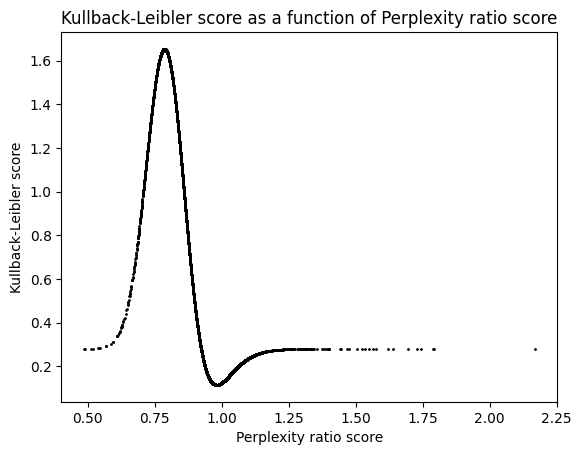

In [18]:
plt.title('Kullback-Leibler score as a function of Perplexity ratio score')
plt.scatter(testing_data_df['Perplexity ratio score'], testing_data_df['Perplexity ratio Kullback-Leibler score'], color='black', s = 1)
plt.xlabel('Perplexity ratio score')
plt.ylabel('Kullback-Leibler score')
plt.show()

In [19]:
# Save as JSON for later use
output_file = config.COMBINED_SCORED_HANS_TESTING_DATA_PR

with open(output_file, 'w') as file:
    file.write(testing_data_df.to_json())

Finaly, save the Kullback–Leibler kernel density estimate for future use.

In [20]:
from pickle import dump

output_file = config.PERPLEXITY_RATIO_KL_KDE

with open(output_file, 'wb') as file:
    dump(kl_kde, file, protocol = 5)